In [262]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
from typing import Optional,Tuple
plt.style.use('fivethirtyeight')

In [263]:
try:
    df_growth = pd.read_csv('/Users/subhamrath/Documents/india_data/data/gdp_growth_data.csv')
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")
    
try:
    df_inflation = pd.read_csv('/Users/subhamrath/Documents/india_data/data/cpi_data.csv')
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

In [264]:
import pandas as pd
from pandas import DataFrame
from typing import Dict

def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans and formats indicators data.

    Args:
        data (DataFrame): Input DataFrame containing indicator data.

    Returns:
        DataFrame: Cleaned and formatted DataFrame.
    """
    df_filtered = data.iloc[:5, 2:]
    df_filtered = df_filtered[['Country Name', '2004 [YR2004]',
                               '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]', '2008 [YR2008]',
                               '2009 [YR2009]', '2010 [YR2010]', '2011 [YR2011]', '2012 [YR2012]',
                               '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]',
                               '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]',
                               '2021 [YR2021]', '2022 [YR2022]']]
    df_filtered.columns = ['Country', '2004',
                           '2005', '2006', '2007', '2008',
                           '2009', '2010', '2011', '2012',
                           '2013', '2014', '2015', '2016',
                           '2017', '2018', '2019', '2020',
                           '2021', '2022']
    return df_filtered.set_index('Country')

def get_gdp_dict(gdp_growth_data: pd.DataFrame) -> pd.DataFrame:
    """
    Computes a dictionary of relative GDP growth compared to India.

    Args:
        gdp_growth_data (DataFrame): Input DataFrame containing GDP growth data for multiple countries.

    Returns:
        DataFrame: DataFrame with relative GDP growth data.
    """
    relative_gdp_dict: Dict[str, Series] = {}
    gdp_growth_india = gdp_growth_data['India']
    for country in gdp_growth_data.columns:
        if country != 'India':
            relative_gdp_dict[f'India:{country}'] = gdp_growth_india - gdp_growth_data[country]
    return pd.DataFrame(relative_gdp_dict)

def calculate_relative_gdp(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Calculates and compares relative GDP growth for the UPA and NDA regimes.

    Args:
        data (DataFrame): Input DataFrame containing GDP growth data for both regimes.

    Returns:
        Tuple[DataFrame, DataFrame, DataFrame, DataFrame]: A tuple of DataFrames containing:
        - relative_gdp_upa (DataFrame): Relative GDP growth during the UPA regime.
        - relative_gdp_nda (DataFrame): Relative GDP growth during the NDA regime.
        - mean_growth_df (DataFrame): Mean relative GDP growth for both regimes.
        - sd_growth_df (DataFrame): Standard deviation of relative GDP growth for both regimes.
    """
    upa_regime = data.iloc[:, :11]
    nda_regime = data.iloc[:, 11:]

    relative_gdp_upa = get_gdp_dict(upa_regime.T)
    relative_gdp_nda = get_gdp_dict(nda_regime.T)

    mean_growth_df = pd.DataFrame([relative_gdp_upa.mean(), relative_gdp_nda.mean()])
    mean_growth_df.index = ['UPA', 'NDA']

    sd_growth_df = pd.DataFrame([relative_gdp_upa.std(), relative_gdp_nda.std()])
    sd_growth_df.index = ['UPA', 'NDA']

    return relative_gdp_upa, relative_gdp_nda, mean_growth_df, sd_growth_df


def plot_mean_std_bar(mean_growth_df: pd.DataFrame, sd_growth_df: pd.DataFrame, ylab: str, title: str):
    """
    Plot side-by-side bar charts for mean and standard deviation of relative GDP growth.

    Args:
        mean_growth_df (DataFrame): DataFrame containing mean relative GDP growth for UPA and NDA regimes.
        sd_growth_df (DataFrame): DataFrame containing standard deviation of relative GDP growth for UPA and NDA regimes.
        ylab (str): Label for the y-axis.
        title (str): Title of the plot.

    Returns:
        None
    """
    # Set the width of the bars
    bar_width = 0.35

    # Transpose the DataFrames to have 'Category' as columns
    mean_growth_df = mean_growth_df.transpose()
    sd_growth_df = sd_growth_df.transpose()

    # Create side-by-side bar plots for mean and standard deviation using DataFrame.plot
    ax = mean_growth_df.plot(kind='bar', yerr=sd_growth_df, capsize=4, figsize=(10, 6), error_kw={'capsize': 4, 'elinewidth': 1.0})

    # Set labels and title
    ax.set_ylabel(ylab)
    ax.set_title(title)

    # Add a legend
    ax.legend(['UPA', 'NDA'])

    # Annotate y-values on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()



In [265]:

from itertools import combinations
from scipy import stats
import numpy as np
from typing import Tuple

def bootstrap_hypothesis_test(
    dataframe1: pd.DataFrame, 
    dataframe2: pd.DataFrame, 
    dataframe_1_govt_name: str, 
    dataframe_2_govt_name: str, 
    metric_name: str,
    alpha: float = 0.05, 
    num_samples: int = 10000,
) -> DataFrame:
    """
    Perform a bootstrap hypothesis test to compare two DataFrames using a specified metric.

    Args:
        dataframe1 (DataFrame): First DataFrame for the hypothesis test.
        dataframe2 (DataFrame): Second DataFrame for the hypothesis test.
        dataframe_1_govt_name (str): Name of the government/regime associated with DataFrame 1.
        dataframe_2_govt_name (str): Name of the government/regime associated with DataFrame 2.
        metric_name (str): Name of the metric to be used for comparison.
        alpha (float, optional): Significance level for the hypothesis test. Default is 0.05.
        num_samples (int, optional): Number of bootstrap samples to generate. Default is 10,000.

    Returns:
        DataFrame: A DataFrame containing the results of the hypothesis test for each common column.
    """
    # Get the common column names
    common_columns = dataframe1.columns.intersection(dataframe2.columns).tolist()
    
    # Calculate the number of pairs for Bonferroni correction
    num_pairs = len(common_columns)
    
    # Create a DataFrame to store the results
    results_df = pd.DataFrame(columns=["Pair", "Observed Difference in Means", "Bootstrap p-value", "Hypothesis Test Result"])

    for column in common_columns:
        returns_A = dataframe1[column]
        returns_B = dataframe2[column]

        # Combine the returns from both datasets
        combined_returns = np.concatenate((returns_A, returns_B))

        # Compute the observed difference in means
        observed_difference = np.mean(returns_A) - np.mean(returns_B)

        # Create an array to store the bootstrapped differences
        bootstrapped_differences = []

        for _ in range(num_samples):
            # Resample with replacement from the combined dataset
            bootstrap_sample = np.random.choice(combined_returns, size=len(combined_returns), replace=True)

            # Split the bootstrapped sample into two parts
            bootstrap_sample_A = bootstrap_sample[:len(returns_A)]
            bootstrap_sample_B = bootstrap_sample[len(returns_A):]

            # Calculate the difference in means for the bootstrap sample
            bootstrap_difference = np.mean(bootstrap_sample_A) - np.mean(bootstrap_sample_B)
    
            bootstrapped_differences.append(bootstrap_difference)

        # Calculate the p-value
        p_value = (np.sum(np.array(bootstrapped_differences) >= observed_difference) + 1) / (num_samples + 1)

        # Apply Bonferroni correction
        bonferroni_corrected_alpha = alpha / num_pairs

        # Test the hypothesis
        if p_value < bonferroni_corrected_alpha:
            result = f"Reject the null hypothesis: {metric_name} of {dataframe_1_govt_name} is better than {dataframe_2_govt_name}."
        else:
            result = f"Fail to reject the null hypothesis: {metric_name} of {dataframe_1_govt_name} is not better than {dataframe_2_govt_name}."
        
        pd.set_option('display.max_colwidth', None)

        results_df = results_df.append({
            "Pair": column,
            "Observed Difference in Means": observed_difference,
            "Bootstrap p-value": p_value,
            "Hypothesis Test Result": result
        }, ignore_index=True)

    return results_df



def two_sample_t_test(dataframe1, dataframe2, dataframe_1_govt_name, dataframe_2_govt_name, metric_name, alpha=0.05):
    # Get the common column names
    common_columns = dataframe1.columns.intersection(dataframe2.columns).tolist()
    
    # Calculate the number of pairs for Bonferroni correction
    num_pairs = len(common_columns)
    # Create a DataFrame to store the results
    results_df = pd.DataFrame(columns=["Pair", "T-statistic", "P-value", "Hypothesis Test Result"])
    bonferroni_corrected_alpha = alpha / num_pairs


    for column in common_columns:
        returns_A = dataframe1[column]
        returns_B = dataframe2[column]

        # Perform the two-sample t-test
        t_stat, p_value = stats.ttest_ind(returns_A, returns_B)

        # Test the hypothesis
        if p_value < bonferroni_corrected_alpha:
            result = f"Reject the null hypothesis: {metric_name} of {dataframe_1_govt_name} is better than {dataframe_2_govt_name}."
        else:
            result = f"Fail to reject the null hypothesis: {metric_name} of {dataframe_1_govt_name} is not better than {dataframe_2_govt_name}."

        results_df = results_df.append({
            "Pair": column,
            "T-statistic": t_stat,
            "P-value": p_value,
            "Hypothesis Test Result": result
        }, ignore_index=True)

    return results_df




In [239]:
gdp_growth_data = clean_data(df_growth)
inflation_data = clean_data(df_inflation)
#filling in inflation data for Russia in 2022 
# (https://www.statista.com/statistics/276323/monthly-inflation-rate-in-russia/)
inflation_data['2022'].iloc[2] = 13.9
inflation_adjusted_data = gdp_growth_data - inflation_data.astype(float)

/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/3799872440.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflation_data['2022'].iloc[2] = 13.9


In [240]:
relative_gdp_upa, relative_gdp_nda, mean_growth, sd_growth = calculate_relative_gdp(gdp_growth_data)
relative_gdp_upa_infladj, relative_gdp_nda_infladj, mean_growth_infladj, sd_growth_infladg =\
calculate_relative_gdp(inflation_adjusted_data)



Text(0.5, 1.0, 'GDP Growth data')

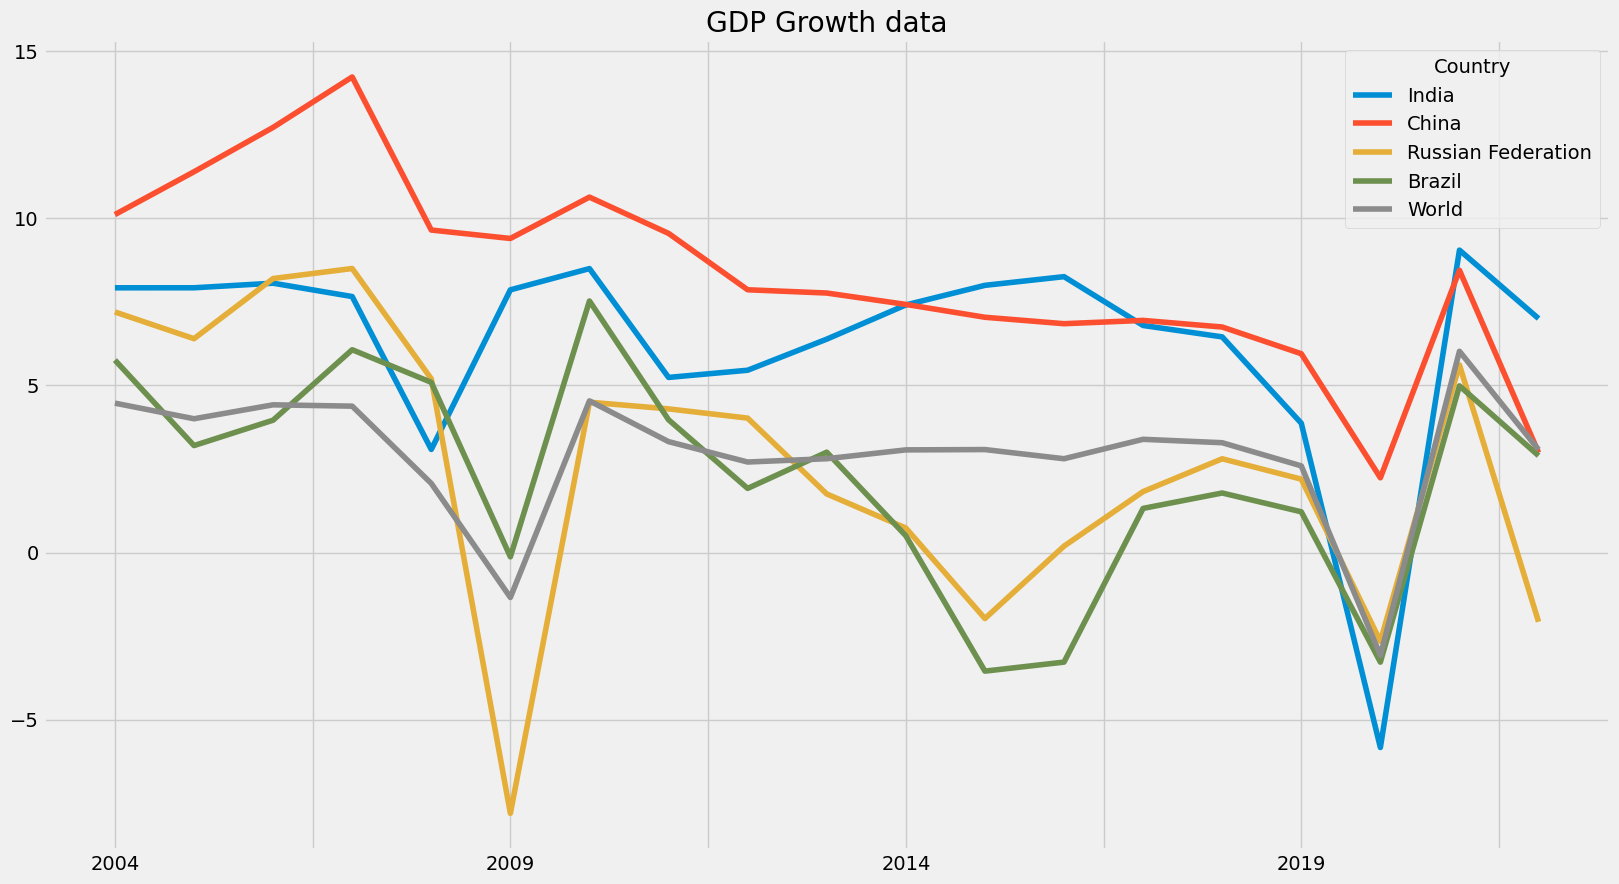

In [249]:

gdp_growth_data.T.plot(figsize = (18,10))
plt.title('GDP Growth data')

Text(0.5, 1.0, 'Inflation data')

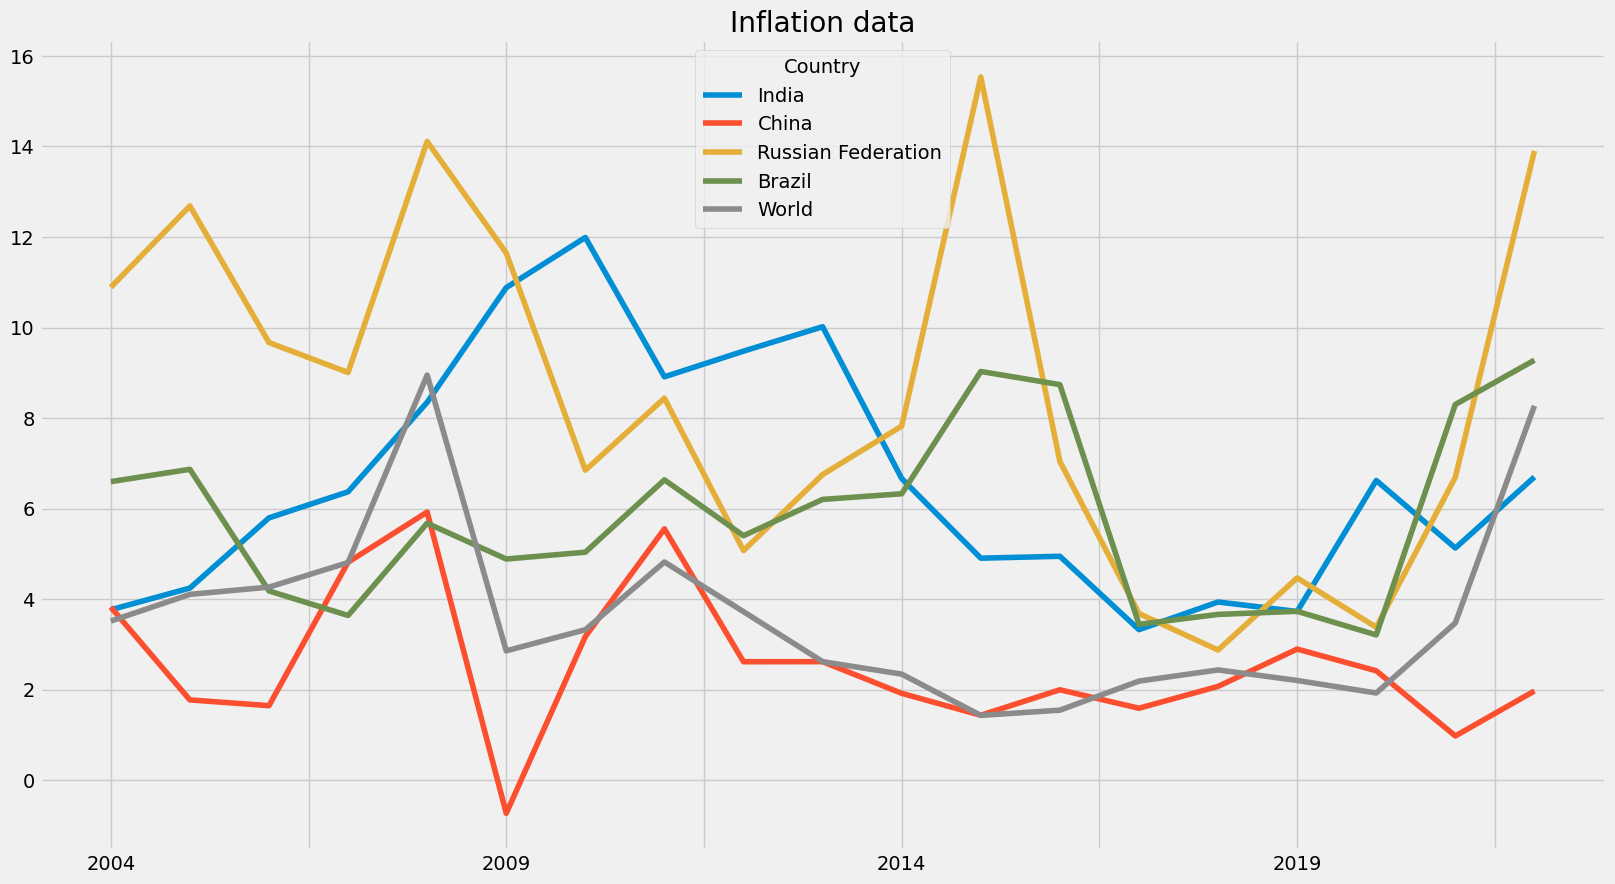

In [251]:
inflation_data.T.astype(float).plot(figsize = (18,10))
plt.title('Inflation data')

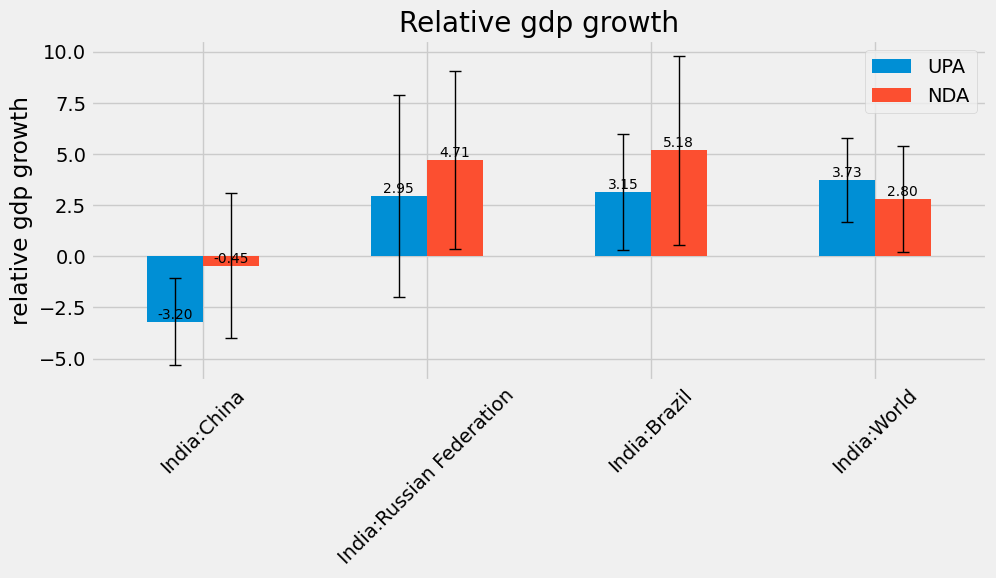

In [212]:
y_lab = 'relative gdp growth'
title = 'Relative gdp growth'
plot_mean_std_bar(mean_growth, sd_growth, y_lab, title)

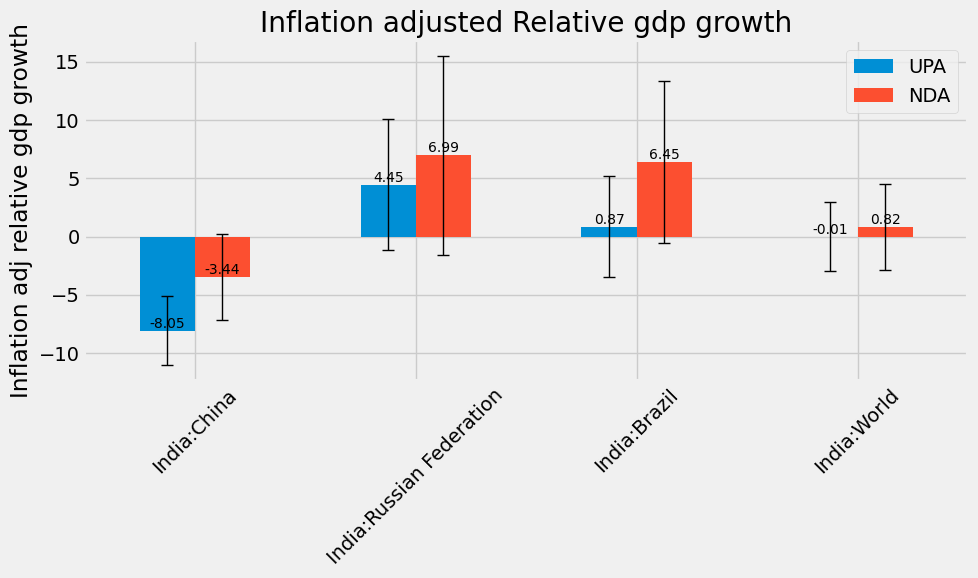

In [213]:
y_lab = 'Inflation adj relative gdp growth'
title = 'Inflation adjusted Relative gdp growth'
plot_mean_std_bar(mean_growth_infladj, sd_growth_infladg, y_lab, title)

In [253]:
bootstrap_hypothesis_test(relative_gdp_nda, relative_gdp_upa, 'NDA','UPA', 'relative_gdp')

/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/1441470428.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/1441470428.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/1441470428.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/1441470428.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.appen

,Pair,Observed Difference in Means,Bootstrap p-value,Hypothesis Test Result
0,India:China,2.751584,0.022998,Fail to reject the null hypothesis: relative_gdp of NDA is not better than UPA.
1,India:Russian Federation,1.752697,0.194581,Fail to reject the null hypothesis: relative_gdp of NDA is not better than UPA.
2,India:Brazil,2.037991,0.109889,Fail to reject the null hypothesis: relative_gdp of NDA is not better than UPA.
3,India:World,-0.931562,0.815418,Fail to reject the null hypothesis: relative_gdp of NDA is not better than UPA.


In [260]:
two_sample_t_test(relative_gdp_nda, relative_gdp_upa, 'NDA','UPA', 'relative_gdp')

/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/673929564.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/673929564.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/673929564.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/673929564.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


,Pair,T-statistic,P-value,Hypothesis Test Result
0,India:China,2.122129,0.048819,Fail to reject the null hypothesis: relative_gdp of NDA is not better than UPA.
1,India:Russian Federation,0.803724,0.432652,Fail to reject the null hypothesis: relative_gdp of NDA is not better than UPA.
2,India:Brazil,1.194519,0.248676,Fail to reject the null hypothesis: relative_gdp of NDA is not better than UPA.
3,India:World,-0.876999,0.392712,Fail to reject the null hypothesis: relative_gdp of NDA is not better than UPA.


In [255]:
bootstrap_hypothesis_test(relative_gdp_nda_infladj, relative_gdp_upa_infladj, 'NDA','UPA', 'relative_gdp_infl_adj')

/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/1441470428.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/1441470428.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/1441470428.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/1441470428.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.appen

,Pair,Observed Difference in Means,Bootstrap p-value,Hypothesis Test Result
0,India:China,4.608168,0.004600,Reject the null hypothesis: relative_gdp_infl_adj of NDA is better than UPA.
1,India:Russian Federation,2.540225,0.205179,Fail to reject the null hypothesis: relative_gdp_infl_adj of NDA is not better than UPA.
2,India:Brazil,5.574107,0.021598,Fail to reject the null hypothesis: relative_gdp_infl_adj of NDA is not better than UPA.
3,India:World,0.830941,0.281372,Fail to reject the null hypothesis: relative_gdp_infl_adj of NDA is not better than UPA.


In [259]:
two_sample_t_test(relative_gdp_nda_infladj, relative_gdp_upa_infladj, 'NDA','UPA', 'relative_gdp_infl_adj')

/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/673929564.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/673929564.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/673929564.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/1c/h4vk74xd10v67g036lvfgwfm0000gn/T/ipykernel_14301/673929564.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


,Pair,T-statistic,P-value,Hypothesis Test Result
0,India:China,3.026159,0.007617,Reject the null hypothesis: relative_gdp_infl_adj of NDA is better than UPA.
1,India:Russian Federation,0.784789,0.443377,Fail to reject the null hypothesis: relative_gdp_infl_adj of NDA is not better than UPA.
2,India:Brazil,2.164670,0.044934,Fail to reject the null hypothesis: relative_gdp_infl_adj of NDA is not better than UPA.
3,India:World,0.545211,0.592690,Fail to reject the null hypothesis: relative_gdp_infl_adj of NDA is not better than UPA.
